# SciBERT_CLOTH

## 綁定雲端硬碟

如果用上面的方式下載了DGen資料集，這步驟可以跳過

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/ML

/content/drive/My Drive/ML


In [ ]:
ls -l

total 8
drwx------ 2 root root 4096 Mar 12 13:21 datasets/
drwx------ 2 root root 4096 Mar 12 13:21 models/


## 引用相關套件

In [ ]:
from tqdm.notebook import tqdm
import json
import re
import os

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 資料預處理

### 資料集處理方式

#### 三個錯誤 + SEP + 正確選項 (CLOTH)

In [ ]:
# 三個錯誤 + SEP + 正確選項
en2num = {"A": 0, "B": 1, "C": 2, "D": 3}

input_list = list()
label_list = list()

for tv in ["train", "valid"]:
  tv_path = os.path.join(r"./datasets/CLOTH", tv)
  for grade in ["high", "middle"]:
    grade_path = os.path.join(tv_path, grade)
    # print(grade_path)

    files = os.listdir(grade_path)
    # print(files)

    for file in tqdm(files):
      full_path = os.path.join(grade_path, file)
      # print(full_path)

      if not file.endswith(".json"):
        continue
      
      with open(full_path, "r") as f:
        dataset = json.load(f)

      sents = nltk.sent_tokenize(dataset["article"])
      options = dataset["options"]
      answers = dataset["answers"]

      i = 0
      for sent in sents:
        # print(sent)
        blank_num = sent.count("_")
        blank_texts = sent.split("_")
        for j in range(blank_num):
          input_text = ""
          label_text1 = ""
          label_text2 = ""
          label_text3 = ""
          k = 0
          for blank_text in blank_texts:
            if k == blank_num:
              answer_index = en2num[answers[i+j]]
              answer = options[i+j][answer_index]

              # masked
              input_text = input_text + blank_text + " [SEP] " + answer
              input_list.append(input_text)
              input_list.append(input_text)
              input_list.append(input_text)

              # 錯誤選項
              label_text1 = label_text1 + blank_text + " [SEP] " + answer
              label_list.append(label_text1)
              label_text2 = label_text2 + blank_text + " [SEP] " + answer
              label_list.append(label_text2)
              label_text3 = label_text3 + blank_text + " [SEP] " + answer
              label_list.append(label_text3)

              # print(input_text)
              # print(label_text)
              # print("-"*50)

              break
            
            # 得到ans和dis的索引值
            ans_index = en2num[answers[i+k]]
            dis_indexs = [0, 1, 2, 3]
            dis_indexs.remove(ans_index)
            # print(ans_index)
            # print(dis_indexs)
            
            if k == j:  # 要被mask的
              input_text = input_text + blank_text + "[MASK]"
              label_text1 = label_text1 + blank_text + options[i+k][dis_indexs[0]]
              label_text2 = label_text2 + blank_text + options[i+k][dis_indexs[1]]
              label_text3 = label_text3 + blank_text + options[i+k][dis_indexs[2]]
            else: # 其他不是被mask的
              ans = options[i+k][ans_index]
              input_text = input_text + blank_text + ans
              label_text1 = label_text1 + blank_text + ans
              label_text2 = label_text2 + blank_text + ans
              label_text3 = label_text3 + blank_text + ans
            
            # print("options:", options[i+k])
            # print("ans_index:", ans_index)
            # print("dis_index:", dis_index)
              
            k += 1
            
        i += blank_num
      
  #     break
  #   break
  # break

  0%|          | 0/3172 [00:00<?, ?it/s]

  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

### 資料集長度

In [ ]:
print(len(input_list))
print(len(label_list))

263751
263751


In [ ]:
print(input_list[:10])
print(label_list[:10])

['A young man with his  [MASK]  was standing nearby and said to the old man, "You old fashioned people read only the Ramayana all the time. [SEP] wife', 'A young man with his  [MASK]  was standing nearby and said to the old man, "You old fashioned people read only the Ramayana all the time. [SEP] wife', 'A young man with his  [MASK]  was standing nearby and said to the old man, "You old fashioned people read only the Ramayana all the time. [SEP] wife', 'Do you not have any other book to  [MASK]  ? [SEP] read', 'Do you not have any other book to  [MASK]  ? [SEP] read', 'Do you not have any other book to  [MASK]  ? [SEP] read', 'The old man continued to read and smiled without any  [MASK]  to the young man. [SEP] reply', 'The old man continued to read and smiled without any  [MASK]  to the young man. [SEP] reply', 'The old man continued to read and smiled without any  [MASK]  to the young man. [SEP] reply', 'Soon, the train  [MASK]  . [SEP] arrived']
['A young man with his  son  was stan

## SciBERT fine-tune

使用 [allenai/scibert_scivocab_uncased](https://huggingface.co/allenai/scibert_scivocab_uncased) 預訓練模型，加上克漏字資料微調。

In [ ]:
!pip install transformers datasets

In [ ]:
BATCH_SIZE = 64
EPOCH = 1

### 建立Dataset

In [ ]:
data_dic = {"input": input_list, "label": label_list}

In [ ]:
from datasets import Dataset

dataset = Dataset.from_dict(data_dic)

In [ ]:
print(len(dataset))

263751


### 建立DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### 微調模型

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = BertForMaskedLM.from_pretrained('allenai/scibert_scivocab_uncased', return_dict=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


In [ ]:
# 進度條
num_training_steps = EPOCH * len(train_loader)
progress_bar = tqdm(range(num_training_steps))

# 開始訓練
loss_history = []
for epoch in range(EPOCH):
  for batch in train_loader:
    inputs = tokenizer(batch["input"], truncation=True, padding="max_length", max_length=50, return_tensors="pt")
    labels = tokenizer(batch["label"], truncation=True, padding="max_length", max_length=50, return_tensors="pt")["input_ids"]
    # print(inputs)
    # print(labels)
    output = model(**inputs.to(device), labels=labels.to(device))
    optimizer.zero_grad()
    loss = output.loss
    logits = output.logits
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()
    progress_bar.update(1)
  
  print(f"[epoch {epoch+1}] loss: {loss.item()}")

  0%|          | 0/4122 [00:00<?, ?it/s]

[epoch 1] loss: 0.945733904838562


In [ ]:
print(loss_history)
print(len(loss_history))

[10.128357887268066, 3.902212142944336, 3.942655086517334, 1.8430944681167603, 1.4905222654342651, 1.2042760848999023, 0.7389163374900818, 1.225016474723816, 0.6414350271224976, 1.0594267845153809, 0.9545189738273621, 0.8092681765556335, 0.769656777381897, 0.9592936635017395, 0.5284540057182312, 0.6824037432670593, 1.0535693168640137, 0.6500862836837769, 0.6019106507301331, 0.7835325598716736, 0.6697368621826172, 0.42992687225341797, 0.6420202851295471, 0.48364418745040894, 0.7038472890853882, 0.5048078298568726, 0.6697186827659607, 0.7155721187591553, 0.4954492151737213, 0.4945524334907532, 0.4540750980377197, 0.5630661249160767, 0.5990204215049744, 0.38209933042526245, 0.7846545577049255, 0.5936359167098999, 0.662360429763794, 0.5009701251983643, 0.7780371308326721, 0.65018630027771, 0.713797926902771, 0.5883417725563049, 0.5294800400733948, 0.3589845299720764, 0.38068535923957825, 0.49052393436431885, 0.3647737205028534, 0.5404588580131531, 0.5846185684204102, 0.5656626224517822, 0.

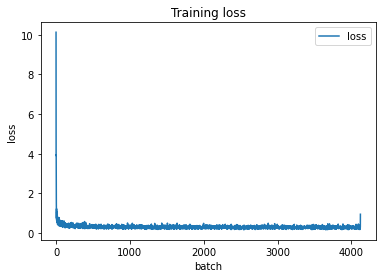

In [ ]:
# paint training loss graph
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['loss'], loc='upper right')
plt.show()

### 模型存檔

In [ ]:
import os

dir_path = r"./models/DGen/"
model_name = "SciBERT_CLOTH_model1"

if not os.path.exists(dir_path):
  os.mkdir(dir_path)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(os.path.join(dir_path, model_name))

In [ ]:
del model
torch.cuda.empty_cache()

## 載入模型並初始化

* BERT_DGen_model1: 三個錯誤 + SEP + 正確, batch=64, epoch=1

In [ ]:
# Test data of CLOTH
text1 = "To make Jane live a [MASK] life, Mother was very careful about spending money. [SEP] happy"
# "happy" -> "poor", "busy", "sad"
text2 = "[MASK] , Jane didn't understand her. [SEP] However"
# "However" -> "Though", "Although", "Or"
text3 = "Every day Mother was busy with her [MASK] while Jane was studying at school, so they had little time to enjoy themselves. [SEP] work"
# "work" -> "writing", "housework", "research"
text4 = "One day, Mother realized Jane was unhappy and even [MASK] to her. [SEP] unfriendly"
# "unfriendly" -> "loyal", "kind", "cruel"
text5 = "The wait seemed [MASK] . [SEP] endless"
# "endless" -> "meaningless", "useless", "careless"
text6 = "The old man was waiting for a ride across the [MASK] . [SEP] river"
# "river" -> "town", "country", "island"
text7 = "I felt uncomfortable and out of place as the professor carefully [MASK] what she expected us to learn. [SEP] explained"
# "explained" -> "showed", "designed", "offered"
text8 = "As I listened, I couldn't help but [MASK] of my own oldest daughter. [SEP] think"
# "think" -> "speak", "talk", "hear"
text9 = "As I listened, I couldn't help but think of my own oldest daughter who was now beginning her first year in [MASK], just like me. [SEP] college"
# "college" -> "school", "office", "classroom"

# Sentence on internet
text10 = "Today morning, I saw a [MASK] sitting on the wall. [SEP] cat"
text11 = "Ukrainian presidential adviser says situation is ' [MASK] control' in suburbs and outskirts of Kyiv. [SEP] under"
text12 = "I don't think that after what is [MASK] now, Ukraine has weak positions. [SEP] happening"

# Test data of DGen
text13 = "If an object is attracted to a magnet, the object is most likely made of [MASK]. [SEP] metal"
# "metal" -> "wood", "plastic", "cardboard"
text14 = "the main organs of the respiratory system are [MASK]. [SEP] lungs"
# "lungs" -> "ovaries", "intestines", "kidneys"
text15 = "The products of photosynthesis are glucose and [MASK] else. [SEP] oxygen"
# "oxygen" -> "carbon", "hydrogen", "nitrogen"
text16 = "frogs have [MASK] eyelid membranes. [SEP] three"
# "three" -> "two", "four", "one"
text17 = "the only known planet with large amounts of water is [MASK]. [SEP] earth"
# "earth" -> "saturn", "jupiter", "mars"

In [ ]:
questions = {
    "q1": {
        "sentence": "To make Jane live a [MASK] life, Mother was very careful about spending money. [SEP] happy",
        "answer": "happy",
        "distractors": ["poor", "busy", "sad"]
    },
    "q2": {
        "sentence": "[MASK] , Jane didn't understand her. [SEP] However",
        "answer": "However",
        "distractors": ["Though", "Although", "Or"]
    },
    "q3": {
        "sentence": "Every day Mother was busy with her [MASK] while Jane was studying at school, so they had little time to enjoy themselves. [SEP] work",
        "answer": "work",
        "distractors": ["writing", "housework", "research"]
    },
    "q4": {
        "sentence": "One day, Mother realized Jane was unhappy and even [MASK] to her. [SEP] unfriendly",
        "answer": "unfriendly",
        "distractors": ["loyal", "kind", "cruel"]
    },
    "q5": {
        "sentence": "The old man was waiting for a ride across the [MASK] . [SEP] river",
        "answer": "river",
        "distractors": ["town", "country", "island"]
    },
    "q6": {
        "sentence": "I felt uncomfortable and out of place as the professor carefully [MASK] what she expected us to learn. [SEP] explained",
        "answer": "explained",
        "distractors": ["showed", "designed", "offered"]
    },
    "q7": {
        "sentence": "As I listened, I couldn't help but [MASK] of my own oldest daughter. [SEP] think",
        "answer": "think",
        "distractors": ["speak", "talk", "hear"]
    },
    "q8": {
        "sentence": "As we were [MASK] on the third floor for old people with Alzheimer, most of them stared off at the walls or floor. [SEP] singing",
        "answer": "singing",
        "distractors": ["meeting", "gathering", "dancing"]
    },
    "q9": {
        "sentence": "As we got [MASK] with each song, she did as well. [SEP] louder",
        "answer": "louder",
        "distractors": ["higher", "nearer", "faster"]
    },
    "q10": {
        "sentence": "Mr. Petri, [MASK] injured in the fire, was rushed to hospital. [SEP] seriously",
        "answer": "seriously",
        "distractors": ["blindly", "hardly", "slightly"]
    },
    "q11": {
        "sentence": "If an object is attracted to a magnet, the object is most likely made of [MASK]. [SEP] metal",
        "answer": "metal",
        "distractors": ["wood", "plastic", "cardboard"]
    },
    "q12": {
        "sentence": "the main organs of the respiratory system are [MASK]. [SEP] lungs",
        "answer": "lungs",
        "distractors": ["ovaries", "intestines", "kidneys"]
    },
    "q13": {
        "sentence": "The products of photosynthesis are glucose and [MASK] else. [SEP] oxygen",
        "answer": "oxygen",
        "distractors": ["carbon", "hydrogen", "nitrogen"]
    },
    "q14": {
        "sentence": "frogs have [MASK] eyelid membranes. [SEP] three",
        "answer": "three",
        "distractors": ["two", "four", "one"]
    },
    "q15": {
        "sentence": "the only known planet with large amounts of water is [MASK]. [SEP] earth",
        "answer": "earth",
        "distractors": ["saturn", "jupiter", "mars"]
    },
    "q16": {
        "sentence": "[MASK] is responsible for erosion by flowing water and glaciers. [SEP] gravity",
        "answer": "gravity",
        "distractors": ["kinetic", "electromagnetic", "weight"],
    },
    "q17": {
        "sentence": "Common among mammals and insects , pheromones are often related to [MASK] type of behavior. [SEP] reproductive",
        "answer": "reproductive",
        "distractors": ["aggressive", "immune", "cardiac"]
    },
    "q18": {
        "sentence": "[MASK] can reproduce by infecting the cell of a living host. [SEP] virus",
        "answer": "virus",
        "distractors": ["bacteria", "mucus", "carcinogens"]
    },
    "q19": {
        "sentence": "proteins are encoded by [MASK]. [SEP] genes",
        "answer": "genes",
        "distractors": ["DNA", "RNA", "codons"]
    },
    "q20": {
        "sentence": "Producers at the base of ecological food webs are also known as [MASK]. [SEP] autotrophic",
        "answer": "autotrophic",
        "distractors": ["endoscopic", "symbiotic", "mutualistic"],
    },
    "q21": {
        "sentence": "Today morning, I saw a [MASK] sitting on the wall. [SEP] cat",
        "answer": "cat",
        "distractors": [],
    },
    "q22": {
        "sentence": "Ukrainian presidential adviser says situation is ' [MASK] control' in suburbs and outskirts of Kyiv. [SEP] under",
        "answer": "under",
        "distractors": [],
    },
    "q23": {
        "sentence": "I don't think that after what is [MASK] now, Ukraine has weak positions. [SEP] happening",
        "answer": "happening",
        "distractors": [],
    },
}

In [ ]:
from transformers import BertTokenizer, BertConfig, BertForMaskedLM
import torch
import os

dir_path = r"./models/DGen/SciBERT_DGen_model1"

tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
config = BertConfig.from_pretrained(os.path.join(dir_path, "config.json"))
model = BertForMaskedLM.from_pretrained(os.path.join(dir_path, "pytorch_model.bin"), config=config, from_tf=False)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
encoded_input = tokenizer(questions["q1"]["sentence"], return_tensors='pt')
output = model(**encoded_input)
print(output)

MaskedLMOutput(loss=None, logits=tensor([[[ 9.5567, -1.8079, -0.7480,  ..., -7.8737, -1.6935, -1.4587],
         [-3.0608, -6.8805, -8.0828,  ..., -7.2407, -8.0295, -8.2121],
         [-3.8045, -4.8117, -7.0642,  ..., -5.7487, -6.7595, -6.5111],
         ...,
         [ 5.5706, -2.7541, -3.7282,  ..., -5.0730, -5.1552, -4.9945],
         [ 5.1310, -2.8234, -3.4627,  ..., -4.6592, -4.5275, -4.6523],
         [ 7.3474, -2.1072, -3.3584,  ..., -4.7238, -4.2794, -4.5303]]],
       grad_fn=<AddBackward0>), hidden_states=None, attentions=None)


### 我的

In [ ]:
from transformers import pipeline
my_unmasker = pipeline('fill-mask', tokenizer=tokenizer, config=config, model=model, top_k=10)

In [ ]:
my_unmasker(questions[question_num]["sentence"])

[{'score': 0.0690985694527626,
  'sequence': 'to make jane live a happy life, mother was very careful about spending money. happy',
  'token': 20942,
  'token_str': 'h a p p y'},
 {'score': 0.06654568016529083,
  'sequence': 'to make jane live a sad life, mother was very careful about spending money. happy',
  'token': 10849,
  'token_str': 's a d'},
 {'score': 0.040321122854948044,
  'sequence': 'to make jane live a dis life, mother was very careful about spending money. happy',
  'token': 271,
  'token_str': 'd i s'},
 {'score': 0.022887015715241432,
  'sequence': 'to make jane live a gri life, mother was very careful about spending money. happy',
  'token': 20589,
  'token_str': 'g r i'},
 {'score': 0.016963621601462364,
  'sequence': 'to make jane live a negative life, mother was very careful about spending money. happy',
  'token': 1980,
  'token_str': 'n e g a t i v e'},
 {'score': 0.01347931195050478,
  'sequence': 'to make jane live a love life, mother was very careful about sp

In [ ]:
question_num = "q19"

sentence = questions[question_num]["sentence"]
answer = questions[question_num]["answer"].lower()
dis = [d.lower() for d in questions[question_num]["distractors"]]

cs1 = list()
for cand in my_unmasker(questions[question_num]["sentence"]):
    cs1.append(cand["token_str"].replace(" ", ""))

print(sentence)
print(answer)
print(dis)
print(cs1)

proteins are encoded by [MASK]. [SEP] genes
genes
['dna', 'rna', 'codons']
['proteins', 'genes', 'chromosomes', 'mutations', 'genomes', 'exons', 'molecules', 'nucleotides', 'enzymes', 'lipids']


### 原本的

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased', top_k=10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
unmasker(text1)

[{'score': 0.29360201954841614,
  'sequence': 'to make jane live a normal life, mother was very careful about spending money. happy',
  'token': 3671,
  'token_str': 'normal'},
 {'score': 0.14251358807086945,
  'sequence': 'to make jane live a better life, mother was very careful about spending money. happy',
  'token': 2488,
  'token_str': 'better'},
 {'score': 0.1040932908654213,
  'sequence': 'to make jane live a good life, mother was very careful about spending money. happy',
  'token': 2204,
  'token_str': 'good'},
 {'score': 0.09106693416833878,
  'sequence': 'to make jane live a happy life, mother was very careful about spending money. happy',
  'token': 3407,
  'token_str': 'happy'},
 {'score': 0.03141509369015694,
  'sequence': 'to make jane live a simple life, mother was very careful about spending money. happy',
  'token': 3722,
  'token_str': 'simple'},
 {'score': 0.025173284113407135,
  'sequence': 'to make jane live a decent life, mother was very careful about spending mo

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-cased')

## Test

In [ ]:
!pip install nltk
import nltk
nltk.download("abc")
from nltk.corpus import abc
nltk.download('punkt')

In [ ]:
import random
def random_mask(input_list):
  masked_list = list.copy(input_list)
  masked_list[random.randint(0, len(input_list)-1)]="[MASK]"
  return masked_list

sentens_list = abc.sents()
input_sentences = [ " ".join(sen) for sen in sentens_list]
masked_sentences = [ " ".join(random_mask(sen)) for sen in sentens_list]

In [ ]:
print(input_sentences[:100])

In [ ]:
print(masked_sentences[:100])

## padding before dataset

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_encodings = tokenizer(inputs_list, truncation=True, padding="max_length", max_length=30, return_tensors="pt")
label_encodings = tokenizer(labels_list, truncation=True, padding="max_length", max_length=30, return_tensors="pt")

In [ ]:
print(input_encodings["input_ids"].shape)
print(label_encodings["input_ids"].shape)

In [ ]:
input_encodings.keys()

In [ ]:
index = 0

print((tokenizer.convert_ids_to_tokens(input_encodings.input_ids[index])))
print()
print(tokenizer.decode(input_encodings.input_ids[index]))
print()
print(input_encodings.attention_mask[index])

In [ ]:
index = 0

print((tokenizer.convert_ids_to_tokens(label_encodings.input_ids[index])))
print()
print(tokenizer.decode(label_encodings.input_ids[index]))
print()
print(label_encodings.attention_mask[index])

In [ ]:
import torch

class WNDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, index):
        input_ids = torch.tensor(self.encodings["input_ids"][index]).squeeze()
        labels = torch.tensor(self.labels["input_ids"][index]).squeeze()
        
        return {"input_ids": input_ids, "labels": labels}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = WNDataset(input_encodings, label_encodings)

In [ ]:
print(train_dataset[0])

In [ ]:
!nvidia-smi

Sat Feb 19 09:37:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------